# Projet 6 : Coordinate gradient descent

In [1]:
from math import *
import random
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error


## Génération de la base de donnée

J'ai décidé de travailler sur un dataset que j'ai généré aléatoirement composé de 6 variables décorrélées. 
Connaissant les coefficients de régression, il est aussi plus simple de s'assurer du bon fonctionnement de la méthode et de l'implémentation de l'algorithme .

In [2]:
random.seed(1)
n=1000
nbr_var=6
x=np.zeros((n,nbr_var))
sd=10
mu=50
for i in range(nbr_var):
  x[:,i]= np.random.randn(n)*sd+mu
design=pd.DataFrame(x,columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
coef=np.array([6,4,0.8,0.02,7,3.8]).reshape(-1,1)
y=np.dot(design,coef)+np.random.randn(n).reshape(-1,1)

In [3]:
#Séparation du training set et du test set
X_train,X_test,y_train,y_test=train_test_split(design,y,test_size=0.33, random_state=1)

In [4]:
#Plus grand valeur propre de la matrice de XX.T
max_ev=max(np.linalg.eigvals(np.dot(X_train, X_train.T))).real
# Nous obtenons la borne supérieur du pas que nous pouvons utilisant grace au résulat théorique suivant 
step=1/max_ev
step

9.761200582556666e-08

## Implémentation de la fonction de perte ridge et de l'algorithme de descente de gradient classique

In [5]:
# Définition de la fonction de perte
def ridge_error(y,X,beta,lambd):

  return(((np.dot(X,beta)-y)**2).sum()/2+lambd*(beta**2).sum()/2)/len(y)

In [6]:
def gradient_descent_ridge(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):
    """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  
  std : float, default=1.
      Standard-deviation of the noise

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
    ridge=[]
    beta = pd.DataFrame([0,0,0,0,0,0]) # Initialisation des coefficients
    for i in range(epochs):
      if i%(epochs/100)==0 and monit: #monitoring
        print("itération {} en cours ...".format(i))
      # Updating beta
      delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
      gradient=np.dot(X.T,delta)+ lambd*beta
      beta_new= beta-learningrate * gradient # on retire un gradient
      ridge.append(ridge_error(y,X,beta_new,lambd)) # on calcule l'erreur
      
      if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=beta_new
     
    return beta,ridge

## Question 1

Rappelons la direction de descente de la random block cordinate descent:
$$ \nabla g_j(\beta) = 2 \left(X_j^T (X\beta - y) + \lambda \beta_j \right) $$

- $X_j$ correspond à la colonne de la $j^{em}$ variable 
- $\beta_j$ le coefficient correspondant à la $j^{em}$ variable.

In [7]:
# Cette fonction permet de calculer le gradient par bloc
def grad_RBCD(X, y, beta, lambd, i):
    return np.array(2 * (X[:, i].transpose().dot(X.dot(beta) - y) + lambd * beta[i]))

def gradient_RBCD(X, y, lambd, iter, learningrate, b_size,arret=False):
  """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  iter: int
    Nombre d'itération

  """  
  X=np.array(X)
  y=np.array(y)
  n, d = X.shape
  beta = np.zeros(d).reshape(-1,1)  #On initialise beta
  e_i = np.eye(d)
  loss_ridge = []
  
  for nb_iter in range(iter):
      block = random.sample(range(d), b_size) # On choisit les variables pour la descent de gradient par block
      g=np.sum([grad_RBCD(X, y, beta, lambd, i) * e_i[i,:] for i in block], axis = 0) # On calcule la direction de descent
      beta_new = beta - learningrate * g.reshape(-1,1)
      loss_ridge.append( ridge_error(y,X,beta_new,lambd)) # On calcule l'erreur
      beta = beta_new
      
      
  return beta, loss_ridge

In [8]:
lambd = 2 
b_size = 2 
iter = 5000
epsilon = 1e-8
beta_RBCD, loss_beta_RBCD = gradient_RBCD(X_train, y_train, lambd, iter, step, b_size)
beta_GD, loss_beta_GD = gradient_descent_ridge(X_train.values, y_train, lambd, step, iter, epsilon, monit=False, arret=False)

In [9]:
beta_RBCD

array([[5.9956142 ],
       [4.00016886],
       [0.80021973],
       [0.02121203],
       [7.00459645],
       [3.79883527]])

Les coefficients trouvés sont proches des coefficients réels

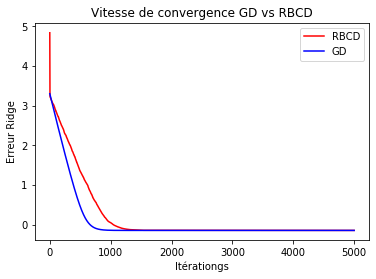

In [10]:
plt.title("Vitesse de convergence GD vs RBCD")
plt.plot( np.log10(loss_beta_RBCD), color = "red", label = "RBCD")
plt.plot( np.log10(loss_beta_GD), color = "blue", label = "GD")
plt.legend(loc = "upper right")
plt.xlabel("Itérationgs")
plt.ylabel('Erreur Ridge')
plt.show()

Sur le graphe ci-dessus, on observe que la descente de gradient converge plus vite que la descente de gradient  RBCD. Néanmoins si on prend en compte le temps d'execution, le RBCD est plus rapide car on divise le nombre de calcul et d'accès aux données par le nombre de block.



## Question 2:

Nous allons combiner dans cette partie le gradient stochastique et le coordinate gradient descente.

Nous utiliserons la direction de descente suivante:
$$ \nabla g_{ij}(\beta) = 2 \left(X_{i,j}^T (X_i\beta - y_i) + \lambda \beta_j \right) $$


In [11]:
#Fonction qui permet de calculer la direction de descente
def grad_RBCD_SGD(X, y, beta, lambd, i, j):
  return 2 * (X[i,j] * (X[i,:].dot(beta)-y[i]) + lambd * beta[j])

def gradient_RBCD_SGD(X, y, lambd, iter, learningrate, b_size):
  X=np.array(X)
  y=np.array(y)
  n, d = X.shape 
  beta = np.zeros(d) 
  e_i = np.eye(d)
  loss_ridge = []
  for epoch in range(iter):
    for nb_iter in range(n):
        
      i = np.random.randint(0, n) #random observation for SGD
      block = random.sample(range(d), b_size) #random block for RBCD
      g=np.sum([grad_RBCD_SGD(X, y, beta, lambd, i, j) * e_i[j,:] for j in block], axis = 0)
      beta_new = beta - learningrate * g
      beta = beta_new 

    loss_ridge.append( ridge_error(y,X,beta,lambd))
      
     
  return beta, loss_ridge

In [12]:
lambd = 10 
b_size = 3 
iter_max = 1000
beta_RBCD_SGD, loss_beta_RBCD_SGD = gradient_RBCD_SGD(X_train, y_train, lambd, iter,step, b_size)

In [13]:
beta_RBCD_SGD

array([5.76878665, 4.01813137, 1.00453469, 0.33724955, 6.70940877,
       3.77912991])

La solution trouvée par la combinaison de l'algorithme de coordinate descent et de l'algorithme de descent de gradient stochastique n'est pas aussi proche de la vraie solution que pour le RBCD seul ou encore la descente de gradient classique. Néanmois il s'agit d'une bonne approximation de la solution.

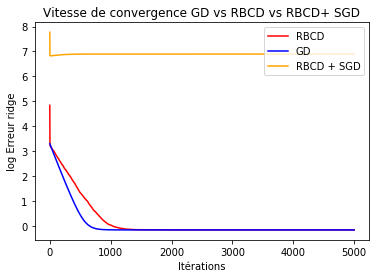

In [14]:

plt.title("Vitesse de convergence GD vs RBCD vs RBCD+ SGD")
plt.plot( np.log10(loss_beta_RBCD), color = "r", label = "RBCD")
plt.plot( np.log10(loss_beta_GD), color = "blue", label = "GD")
plt.plot( np.log10(loss_beta_RBCD_SGD), color = "orange", label = "RBCD + SGD")
plt.legend(loc = "upper right")
plt.xlabel("Itérations")
plt.ylabel('log Erreur ridge')
plt.show()

On peut observer le résultat théorique suivant: 

La descente de gradient stochastique ne converge qu'à un voisinage de la solution réelle.

On peut observer également que la combinaison RBCD et SDG converge beaucoup plus vite même si ce n'est qu'à un voisinage de la solution.

Ainsi l'intérêt de combiner l'algorithme de coordinate gradient descente et l'algorithme du gradient stochastique est d'accéler la vitesse de convergence.

Une autre idée serait d'utiliser l'algorithme de minibatch stochastique gradient ou une autre méthode de réduction de variance pour arriver à un voisinage plus proche de la vraie solution tout en conservant l'avantage de la vitesse de convergence.